In [4]:
import math
import h5py
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial

2.1.0+cu121


In [5]:
# importing data onto Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# TODO

Create 3 models for each region with exact same architecture (1 output neuron, no standardization needed)

Apply early stopping using validation set

Create time series plot of test data vs CNN vs El Nino plot with years for each region

Fourth person: think of creative architectures (potentially dropout?). Will be responsible for preparing real world data.

El Nino model with same train/val/test simulations


# CNN

### Prepare Data for CNN in PyTorch

In [6]:
#ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
ds2 = xr.open_dataset("/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 ...

In [7]:
#PRECT = pd.read_csv('Detrended_PRECT.csv')
PRECT = pd.read_csv('/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_PRECT.csv')
PRECT = PRECT.set_index(['simulation', 'year', 'region'])
PRECT.head()

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542

In [8]:
y = PRECT.to_numpy()
y.shape

(22200, 1)

In [9]:
y

array([[ 1.69681626],
       [-4.38486059],
       [ 2.35965193],
       ...,
       [ 1.42676119],
       [-2.24789536],
       [ 2.00405384]])

In [10]:
y = y.reshape(-1, 3)
y.shape

(7400, 3)

In [11]:
y_reshaped = y.reshape(100, 74, 3)
y_reshaped.shape

(100, 74, 3)

In [12]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [13]:
X_reshaped = X.reshape(100, 74, 192, 288)
X_reshaped.shape

(100, 74, 192, 288)

In [14]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [15]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1/.9, random_state=49)

#Create Dataloader Objects for PyTorch
#BATCH_SIZE = 16
BATCH_SIZE = 32

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()
X_val = from_numpy(X_val).float()
y_val = from_numpy(y_val).float()
X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

print("After train/val/test split, before reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

X_train = X_train.view(-1, 192, 288)
X_test = X_test.view(-1, 192, 288)
X_val = X_val.view(-1, 192, 288)
y_train = y_train.view(-1, 3)
y_test = y_test.view(-1, 3)
y_val = y_val.view(-1, 3)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_valid = TensorDataset(X_val, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

#Check shape of resulting objects
print("After train/val/test split, after reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


After train/val/test split, before reshaping
torch.Size([80, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([80, 74, 3])
torch.Size([10, 74, 3])
torch.Size([10, 74, 3])
After train/val/test split, after reshaping
torch.Size([5920, 192, 288])
torch.Size([740, 192, 288])
torch.Size([740, 192, 288])
torch.Size([5920, 3])
torch.Size([740, 3])
torch.Size([740, 3])


In [16]:
for batch in dataloader_train:
    predictor_batch, target_batch = batch
    print(predictor_batch.shape)
    break

torch.Size([32, 192, 288])


### Build CNN

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, stride = (2,2), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 9, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)  # 3 output values

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 16 * 6 * 9)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net()
model

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=864, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [18]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

179827

In [19]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 5

### Train CNN

In [20]:
%%time

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_train, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.unsqueeze(1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 16 == 15:    # print every 16 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 16:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    16] loss: 23.196
[1,    32] loss: 25.522
[1,    48] loss: 23.679
[1,    64] loss: 25.492
[1,    80] loss: 28.443
[1,    96] loss: 25.976
[1,   112] loss: 26.553
[1,   128] loss: 23.669
[1,   144] loss: 26.804
[1,   160] loss: 22.119
[1,   176] loss: 24.154
[2,    16] loss: 26.237
[2,    32] loss: 25.114
[2,    48] loss: 23.448
[2,    64] loss: 24.378
[2,    80] loss: 26.255
[2,    96] loss: 25.324
[2,   112] loss: 25.287
[2,   128] loss: 23.666
[2,   144] loss: 24.312
[2,   160] loss: 25.412
[2,   176] loss: 26.742
[3,    16] loss: 26.449
[3,    32] loss: 25.739
[3,    48] loss: 25.778
[3,    64] loss: 26.355
[3,    80] loss: 25.553
[3,    96] loss: 28.047
[3,   112] loss: 22.847
[3,   128] loss: 24.352
[3,   144] loss: 24.009
[3,   160] loss: 24.335
[3,   176] loss: 24.475
[4,    16] loss: 24.178
[4,    32] loss: 24.851
[4,    48] loss: 24.734
[4,    64] loss: 25.449
[4,    80] loss: 26.437
[4,    96] loss: 25.423
[4,   112] loss: 23.627
[4,   128] loss: 23.991
[4,   144] loss:

### Tune CNN

### Test CNN

In [21]:
predicted_data = []
actual_data = []

# Set the model to evaluation mode
model.eval()

# Iterate through the test dataloader
with torch.no_grad():
    for data in dataloader_test:
        inputs, labels = data
        inputs = inputs.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)

        # Convert torch tensors to numpy arrays
        predicted_data.extend(outputs.numpy())
        actual_data.extend(labels.numpy())

In [22]:
# Convert lists to numpy arrays
predicted_data = np.array(predicted_data)
actual_data = np.array(actual_data)

# Print the shapes of the predicted and actual data arrays
print("Predicted Data Shape:", predicted_data.shape)
print("Actual Data Shape:", actual_data.shape)

Predicted Data Shape: (740, 3)
Actual Data Shape: (740, 3)


In [23]:
predicted_data

array([[-0.02471353, -0.01913393, -0.00743254],
       [-0.02234151, -0.02312403,  0.00404581],
       [-0.01439925, -0.02330111,  0.00372428],
       ...,
       [-0.02255641, -0.01746448, -0.0071663 ],
       [-0.02415139, -0.02413261,  0.00289403],
       [-0.01763035, -0.02877168,  0.00213091]], dtype=float32)

In [24]:
actual_data

array([[ 5.6458964 ,  6.034231  ,  4.4701576 ],
       [ 4.0199647 ,  6.184253  ,  3.4664485 ],
       [ 0.11750881, -2.7709303 ,  1.5453911 ],
       ...,
       [ 2.4003453 ,  0.36949238,  0.53987193],
       [ 0.7403478 , 14.040306  , -3.2507973 ],
       [-1.6702483 , -8.658639  ,  0.9163426 ]], dtype=float32)

In [25]:
sim1_north_predicted = predicted_data[:74, 1]
sim1_north_actual = actual_data[:74, 1]

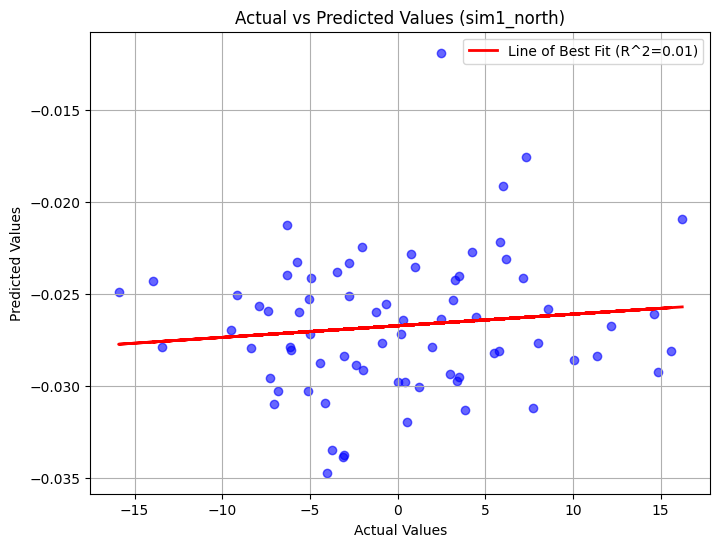

In [26]:
# Fit linear regression model
regression_model = LinearRegression()
regression_model.fit(sim1_north_actual.reshape(-1, 1), sim1_north_predicted.reshape(-1, 1))
predicted_values = regression_model.predict(sim1_north_actual.reshape(-1, 1))
r2_value = r2_score(sim1_north_predicted, predicted_values)

# Plot scatter plot with line of best fit
plt.figure(figsize=(8, 6))
plt.scatter(sim1_north_actual, sim1_north_predicted, color='blue', alpha=0.6)
plt.plot(sim1_north_actual, predicted_values, color='red', linewidth=2, label=f'Line of Best Fit (R^2={r2_value:.2f})')
plt.title('Actual vs Predicted Values (sim1_north)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()
plt.show()


In [27]:
sim1_central_predicted = predicted_data[:74, 0]
sim1_central_actual = actual_data[:74, 0]

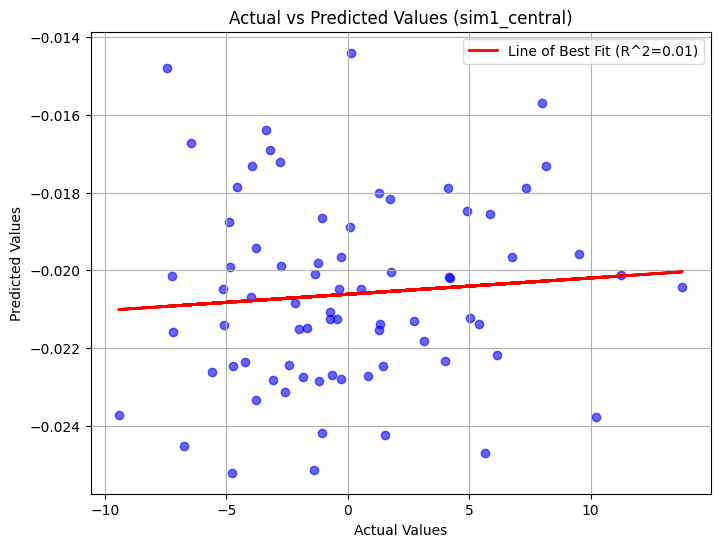

In [28]:
# Fit linear regression model
regression_model = LinearRegression()
regression_model.fit(sim1_central_actual.reshape(-1, 1), sim1_central_predicted.reshape(-1, 1))
predicted_values = regression_model.predict(sim1_central_actual.reshape(-1, 1))
r2_value = r2_score(sim1_central_predicted, predicted_values)

# Plot scatter plot with line of best fit
plt.figure(figsize=(8, 6))
plt.scatter(sim1_central_actual, sim1_central_predicted, color='blue', alpha=0.6)
plt.plot(sim1_central_actual, predicted_values, color='red', linewidth=2, label=f'Line of Best Fit (R^2={r2_value:.2f})')
plt.title('Actual vs Predicted Values (sim1_central)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
sim1_south_predicted = predicted_data[:74, 2]
sim1_south_actual = actual_data[:74, 2]

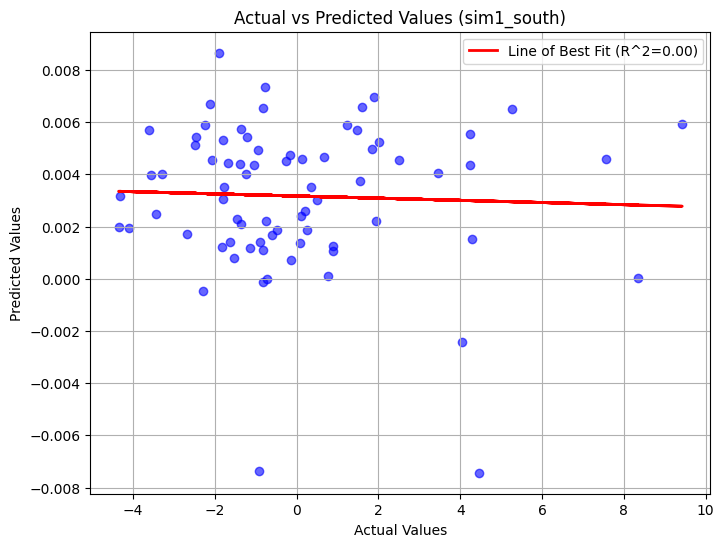

In [30]:
# Fit linear regression model
regression_model = LinearRegression()
regression_model.fit(sim1_south_actual.reshape(-1, 1), sim1_south_predicted.reshape(-1, 1))
predicted_values = regression_model.predict(sim1_south_actual.reshape(-1, 1))
r2_value = r2_score(sim1_south_predicted, predicted_values)

# Plot scatter plot with line of best fit
plt.figure(figsize=(8, 6))
plt.scatter(sim1_south_actual, sim1_south_predicted, color='blue', alpha=0.6)
plt.plot(sim1_south_actual, predicted_values, color='red', linewidth=2, label=f'Line of Best Fit (R^2={r2_value:.2f})')
plt.title('Actual vs Predicted Values (sim1_south)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()
plt.show()


## Potential Resources

https://www.nature.com/articles/s41598-020-57897-9

https://www.nature.com/articles/s41586-019-1559-7
- first architecture option